In [2]:
import os
import torch
from torch import mps
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from time import time
from tqdm import tqdm

# Loda data

In [3]:
batch_size = 24

def get_transforms(train_or_val: str,
                   model_name: str) -> torchvision.transforms.Compose:
    if model_name == 'inception':
        resize_num = 299
        means = [0.485, 0.456, 0.406]
        stds = [0.229, 0.224, 0.225]
    else: 
        resize_num =  224
        means = stds = [0.5] * 3
    
    return torchvision.transforms.Compose(
        ([torchvision.transforms.RandomResizedCrop(resize_num),
         torchvision.transforms.RandomHorizontalFlip()] if train_or_val == 'train' else 
        [torchvision.transforms.Resize(int(resize_num/224*256)), 
         torchvision.transforms.CenterCrop(resize_num)]) + 
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize(means, stds)
        ])

class ImageFolderWithName(torchvision.datasets.ImageFolder):
    def __getitem__(self, index: int):
        path, target = self.samples[index]
        image = self.loader(path)
        
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        name = os.path.basename(path)
        
        return image, target, name

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

model_names = ['vit', 'inception']
data_dir = os.path.join(os.getcwd(),'data/FineGrainDataset')
datasets = {f'{model_name}_{train_or_val}': ImageFolderWithName(root=os.path.join(data_dir, train_or_val),
                                                           transform=
                                                           get_transforms(train_or_val=train_or_val,
                                                                          model_name=model_name)) 
            for model_name in model_names for train_or_val in ['train', 'val']}

assert all(datasets[f'{model_name}_train'].classes == 
           datasets[f'{model_name}_val'].classes for model_name in model_names)

# Define a custom DataLoader worker init function with a fixed random seed
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)


loaders = {f'{model_name}_{train_or_val}':
               torch.utils.data.DataLoader(dataset=datasets[f'{model_name}_{train_or_val}'],
                                           batch_size=batch_size,
                                           shuffle=True,
                                           worker_init_fn=worker_init_fn)
           for model_name in model_names for train_or_val in ['train', 'val']}

classes = datasets['vit_train'].classes
classes

['2S19_MSTA',
 '30N6E',
 'BM-30',
 'BMD',
 'BMP-1',
 'BMP-2',
 'BMP-T15',
 'BRDM',
 'BTR-60',
 'BTR-70',
 'BTR-80',
 'D-30',
 'Iskander',
 'MT_LB',
 'Pantsir-S1',
 'Rs-24',
 'T-14',
 'T-62',
 'T-64',
 'T-72',
 'T-80',
 'T-90',
 'TOS-1',
 'Tornado']

In [4]:
n = len(classes)
n

24

In [6]:
device = torch.device('mps' if torch.backends.mps.is_available() else
                      ("cuda" if torch.cuda.is_available() else 'cpu'))

class ClearCache:
    def __init__(self, device):
        self.device_backend = {'cuda': torch.cuda,
                       'mps': mps,
                       'cpu': None}[device.type]

    def __enter__(self):
        if self.device_backend:
            self.device_backend.empty_cache()

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.device_backend:
            self.device_backend.empty_cache()
        
device

device(type='mps')

# Train

In [12]:
class ModelFineTuner(torch.nn.Module):
    def __str__(self):
        return self.__class__.__name__.split('Model')[0].lower()
    
class InceptionModelFineTuner(ModelFineTuner):
    def __init__(self, num_classes: int):
        super(InceptionModelFineTuner, self).__init__()
        self.inception = torchvision.models.inception_v3(
            weights=torchvision.models.Inception_V3_Weights.DEFAULT)
        num_features = self.inception.fc.in_features
        self.inception.fc = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return x

class VITModelFineTuner(ModelFineTuner):
    def __init__(self, num_classes: int):
        super(VITModelFineTuner, self).__init__()
        self.vit = torchvision.models.vit_l_16(weights=torchvision.models.ViT_L_16_Weights.DEFAULT)
        self.vit.heads[-1] = torch.nn.Linear(self.vit.hidden_dim, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return x

vit_fine_tuner = VITModelFineTuner(num_classes=n)
inception_fine_tuner = InceptionModelFineTuner(num_classes=n)
fine_tuners = [inception_fine_tuner, vit_fine_tuner]


def test(fine_tuner: ModelFineTuner) -> (list[int], list[int]):
    test_loader = loaders[f'{fine_tuner}_val']
    fine_tuner.eval()
    correct = 0
    total = 0
    test_prediction = []
    test_ground_truth = []
    name_list = []
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            pred_temp = []
            truth_temp = []
            name_temp = []
            images, labels, names = data[0].to(device), data[1].to(device), data[2] 
            outputs = fine_tuner(images)
            _, predicted = torch.max(outputs.data, 1)
            test_ground_truth += labels.tolist()
            test_prediction += predicted.tolist()
            name_list += names # Collect the name values
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_temp += predicted.tolist()
            truth_temp += labels.tolist()
            name_temp += names
    
    print(f'Test accuracy: '
          f'{round(accuracy_score(y_true=test_ground_truth, y_pred=test_prediction), 3)}')
    
    return test_ground_truth, test_prediction

def fine_tune(fine_tuner: ModelFineTuner,
              lr,
              scheduler_step_size,
              scheduler_gamma) -> (list[int], list[int], list[int], list[int]):
    fine_tuner.to(device)
    fine_tuner.train()
    
    train_loader = loaders[f'{fine_tuner}_train']
    criterion = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(params=fine_tuner.parameters(),
                                lr=lr)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                step_size=scheduler_step_size,
                                                gamma=scheduler_gamma)
    
    train_loss = []
    train_acc = []
    train_ground_truth = []
    train_prediction = []
    
    test_ground_truth = []
    test_prediction = []
    
    
    for epoch in range(num_epochs):
        t1 = time()
        running_loss = 0.0
        train_prediction = []
        train_ground_truth = []
        
        for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = fine_tuner(inputs)
            
            if type(outputs) == torchvision.models.InceptionOutputs:
                outputs = outputs[0]
                
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)
            train_ground_truth += labels.tolist()
            train_prediction += predicted.tolist()
    
        true_labels = np.array(train_ground_truth)
        predicted_labels = np.array(train_prediction)
        acc = accuracy_score(true_labels, predicted_labels)
        print(f'\nModel: {fine_tuner} '
              f'epoch {epoch + 1}/{num_epochs} done in {int(time() - t1)} seconds, '
              f'\ntraining loss: {round(running_loss / len(train_loader),3)}')
        print(f'training accuracy: {round(acc, 3)}\n')
        train_acc.append(acc)
        train_loss.append(running_loss / len(train_loader))
        scheduler.step()
        test_ground_truth, test_prediction = test(fine_tuner)
        print('#' * 100)

    np.save(f'{fine_tuner}_train_acc.npy', train_acc)
    np.save(f'{fine_tuner}_train_loss.npy', train_loss)
    
    return train_ground_truth, train_prediction, test_ground_truth, test_prediction
        
for fine_tuner in fine_tuners:
    with ClearCache(device):
        lr = 0.0002
        scheduler_step_size = 7
        scheduler_gamma = 0.1
        num_epochs = 1
        train_ground_truth, train_prediction, test_ground_truth, test_prediction = fine_tune(fine_tuner, lr, scheduler_step_size, num_epochs)
        np.save(f'{fine_tuner}_pred.npy', test_prediction)
        np.save(f'{fine_tuner}_true.npy', test_ground_truth)
        print('#' * 100)


Model: inception epoch 1/1 done in 14 seconds, 
training loss: 2.448
training accuracy: 0.295
Test accuracy: 0.525
####################################################################################################
####################################################################################################

Model: vit epoch 1/1 done in 227 seconds, 
training loss: 2.065
training accuracy: 0.388
Test accuracy: 0.597
####################################################################################################
####################################################################################################


In [13]:
assert np.all(np.load("inception_true.npy") == np.load("vit_true.npy"))

AssertionError: 

## Train Loss

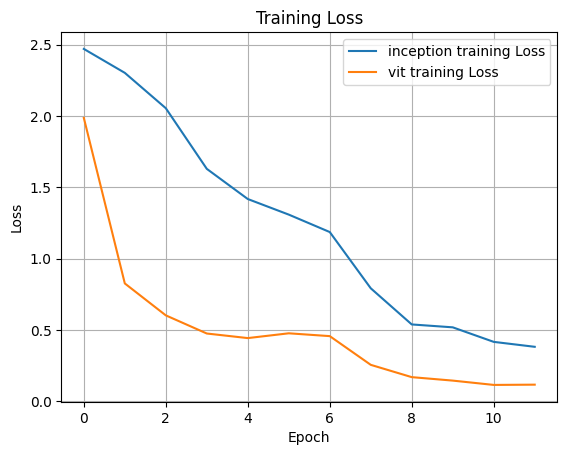

In [7]:
for fine_tuner in [fine_tuners[1]]:
    model_name = fine_tuner.__class__.__name__.split('Model')[0].lower()
    train_loss = np.load(f'{model_name}_train_loss.npy')
    plt.plot(train_loss, label=f'{model_name} training Loss')
    
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Train Accuracy

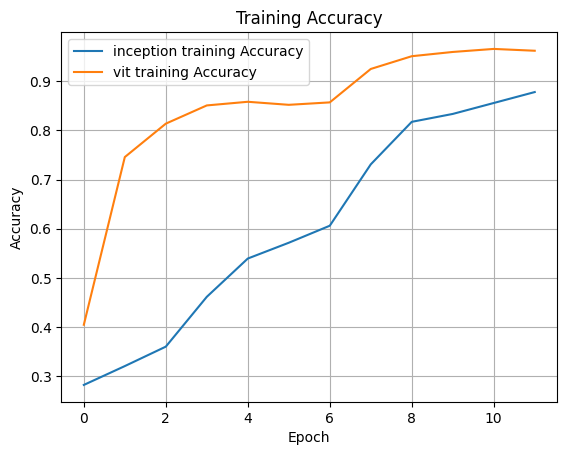

In [10]:
for fine_tuner in [fine_tuners[1]]:
    model_name = fine_tuner.__class__.__name__.split('Model')[0].lower()
    train_acc = np.load(f'{model_name}_train_acc.npy')
    plt.plot(train_acc, label=f'{model_name} training Accuracy')
    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid()

In [51]:
print(classification_report(true_labels, pred, target_names=classes))

                          precision    recall  f1-score   support

             Air Defense       0.87      0.93      0.90        14
                     BMD       0.80      0.73      0.76        22
                     BMP       0.86      0.98      0.92        58
                     BTR       0.96      0.79      0.87        34
                   MT_LB       0.91      0.95      0.93        21
Self Propelled Artillery       0.90      0.69      0.78        26
                    Tank       0.88      0.93      0.90        61

                accuracy                           0.88       236
               macro avg       0.88      0.86      0.87       236
            weighted avg       0.88      0.88      0.88       236


In [15]:
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_labels)
print(cm)

NameError: name 'ground_truth' is not defined

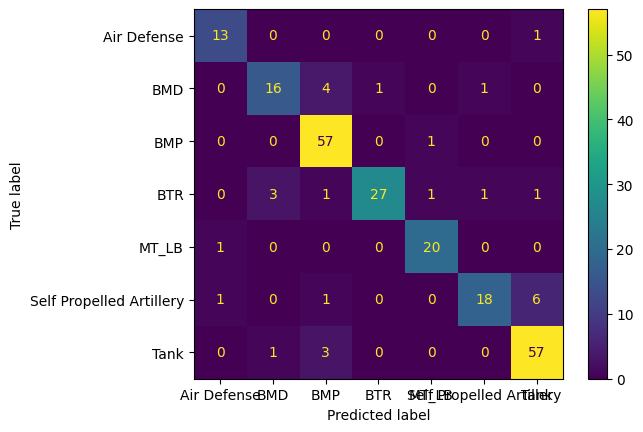

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=classes)

cm_display.plot()
plt.show()